In [1]:
# List all device
from tensorflow.python.client import device_lib
# print(device_lib.list_local_devices())

In [2]:
# Check available GPU
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

Using TensorFlow backend.


[]

In [3]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
# The GPU id to use, usually either "0" or "1";
os.environ["CUDA_VISIBLE_DEVICES"]="0";  

In [4]:
# Importing the libraries
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Reshape, Lambda, GRU, BatchNormalization, Bidirectional
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.activations import softmax
from keras.optimizers import SGD, RMSprop
import math
import pickle
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler

In [5]:
index = "dowjones"
# index = "frankfurt"
with open(f"../data/{index}_calculated/absolute_periods750_250_240.txt", "rb") as fp:   # Unpickling
    dataset = pickle.load(fp)

In [6]:
def calculate_class(returns):
    """Find the class for each LSTM sequence based on the median returns."""
    median_returns = returns.median(axis=1)
    labels = returns.iloc[:, :].apply(lambda x: np.where
                                      (x >= median_returns, 1, 0), axis=0)
    return labels

In [7]:
i = 7
timestep = 240
feature = 31

In [8]:
x_train = dataset[0][i][0].values
x_test = dataset[1][i][0].values

scaler = StandardScaler().fit(x_train)

x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

y_train = to_categorical(dataset[0][i][1].values, 2)
y_test = to_categorical(dataset[1][i][1].values, 2)

In [9]:
print(f"x train shape: {x_train.shape}")
print(f"y train shape: {y_train.shape}")
print(f"x test shape: {x_test.shape}")
print(f"y test shape: {y_test.shape}")

x train shape: (750, 31)
y train shape: (750, 31, 2)
x test shape: (490, 31)
y test shape: (490, 31, 2)


In [10]:
x_series = [x_train[i:i+timestep, :] for i in range(1, x_train.shape[0] - timestep)]
y_series = [y_train[i+timestep] for i in range(y_train.shape[0] - timestep - 1)]
x = np.array(x_series)
y = np.array(y_series)
print(f"x shape: {x.shape}")
print(f"y shape: {y.shape}")

x shape: (509, 240, 31)
y shape: (509, 31, 2)


In [11]:
x_series1 = [x_test[i:i+timestep, :] for i in range(1, x_test.shape[0] - timestep)]
y_series1 = [y_test[i+timestep] for i in range(y_test.shape[0] - timestep - 1)]
x1 = np.array(x_series1)
y1 = np.array(y_series1)
print(f"x1 shape: {x1.shape}")
print(f"y1 shape: {y1.shape}")

x1 shape: (249, 240, 31)
y1 shape: (249, 31, 2)


In [12]:
regressor = Sequential()
regressor.add(LSTM(units=25, input_shape=(timestep, feature)))
regressor.add(Dense(feature * 2, activation='relu'))
regressor.add(Reshape((feature, 2)))
# regressor.add(Lambda(lambda x: softmax(x, axis=-1)))
regressor.add(Dense(2, activation='softmax'))
regressor.compile(loss='binary_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy'])
regressor.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 25)                5700      
_________________________________________________________________
dense_1 (Dense)              (None, 62)                1612      
_________________________________________________________________
reshape_1 (Reshape)          (None, 31, 2)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 31, 2)             6         
Total params: 7,318
Trainable params: 7,318
Non-trainable params: 0
_________________________________________________________________


In [13]:
# result = regressor.fit_generator(train_gen, steps_per_epoch=len(train_gen), epochs=1000)
result = regressor.fit(x, y, epochs=1000, validation_data=(x1, y1), callbacks = [EarlyStopping(monitor='val_loss', mode='min', patience=10),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_acc', save_best_only=True)])

Train on 509 samples, validate on 249 samples
Epoch 1/1000
509/509 [==============================] - 2s 4ms/step - loss: 0.6911 - acc: 0.5222 - val_loss: 0.6892 - val_acc: 0.5599
Epoch 2/1000
509/509 [==============================] - 1s 3ms/step - loss: 0.6839 - acc: 0.5974 - val_loss: 0.6817 - val_acc: 0.6093
Epoch 3/1000
509/509 [==============================] - 1s 3ms/step - loss: 0.6724 - acc: 0.6374 - val_loss: 0.6702 - val_acc: 0.6459
Epoch 4/1000
509/509 [==============================] - 1s 3ms/step - loss: 0.6574 - acc: 0.6703 - val_loss: 0.6572 - val_acc: 0.6720
Epoch 5/1000
509/509 [==============================] - 1s 3ms/step - loss: 0.6420 - acc: 0.6884 - val_loss: 0.6444 - val_acc: 0.6884
Epoch 6/1000
509/509 [==============================] - 1s 3ms/step - loss: 0.6267 - acc: 0.7078 - val_loss: 0.6309 - val_acc: 0.7058
Epoch 7/1000
509/509 [==============================] - 1s 3ms/step - loss: 0.6118 - acc: 0.7218 - val_loss: 0.6181 - val_acc: 0.7190
Epoch 8/1000
509

509/509 [==============================] - 3s 6ms/step - loss: 0.3095 - acc: 0.8675 - val_loss: 0.4149 - val_acc: 0.7995
Epoch 62/1000
509/509 [==============================] - 3s 6ms/step - loss: 0.3062 - acc: 0.8688 - val_loss: 0.4140 - val_acc: 0.7989
Epoch 63/1000
509/509 [==============================] - 3s 6ms/step - loss: 0.3031 - acc: 0.8707 - val_loss: 0.4130 - val_acc: 0.7995
Epoch 64/1000
509/509 [==============================] - 3s 6ms/step - loss: 0.2999 - acc: 0.8720 - val_loss: 0.4128 - val_acc: 0.7998
Epoch 65/1000
509/509 [==============================] - 3s 6ms/step - loss: 0.2969 - acc: 0.8737 - val_loss: 0.4123 - val_acc: 0.8010
Epoch 66/1000
509/509 [==============================] - 3s 6ms/step - loss: 0.2937 - acc: 0.8756 - val_loss: 0.4115 - val_acc: 0.8014
Epoch 67/1000
509/509 [==============================] - 3s 6ms/step - loss: 0.2909 - acc: 0.8775 - val_loss: 0.4108 - val_acc: 0.8018
Epoch 68/1000
509/509 [==============================] - 3s 6ms/step 

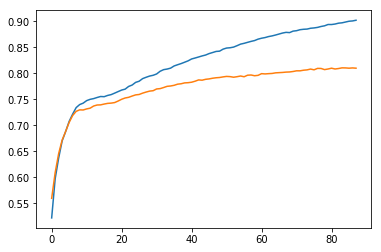

In [14]:
plt.plot(result.history["acc"])
plt.plot(result.history["val_acc"])

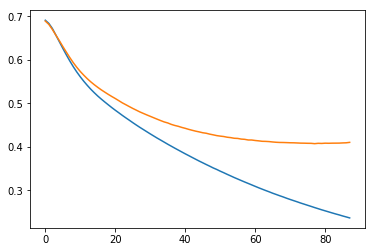

In [15]:
plt.plot(result.history["loss"])
plt.plot(result.history["val_loss"])